In [33]:
import numpy as np
import pandas as pd

import pylab as plt
import seaborn as sns

from scipy import stats as st
from statsmodels.api import add_constant, OLS

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from statsmodels.api import add_constant, OLS
from statsmodels.formula.api import ols

import pylab as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [34]:
casas=pd.read_csv('D:/UAX/2º Curso/IronHack/Proyecto_Final/regression_data1.csv')
casas.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [35]:
cte_cols = []

for c in casas.select_dtypes(include=np.number): # para columnas de tipo numérico
    
    if casas[c].std()==0:
        cte_cols.append(c)
        
cte_cols
# no hay datos duplicados

[]

In [36]:
casas.info()
#no hay datos nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

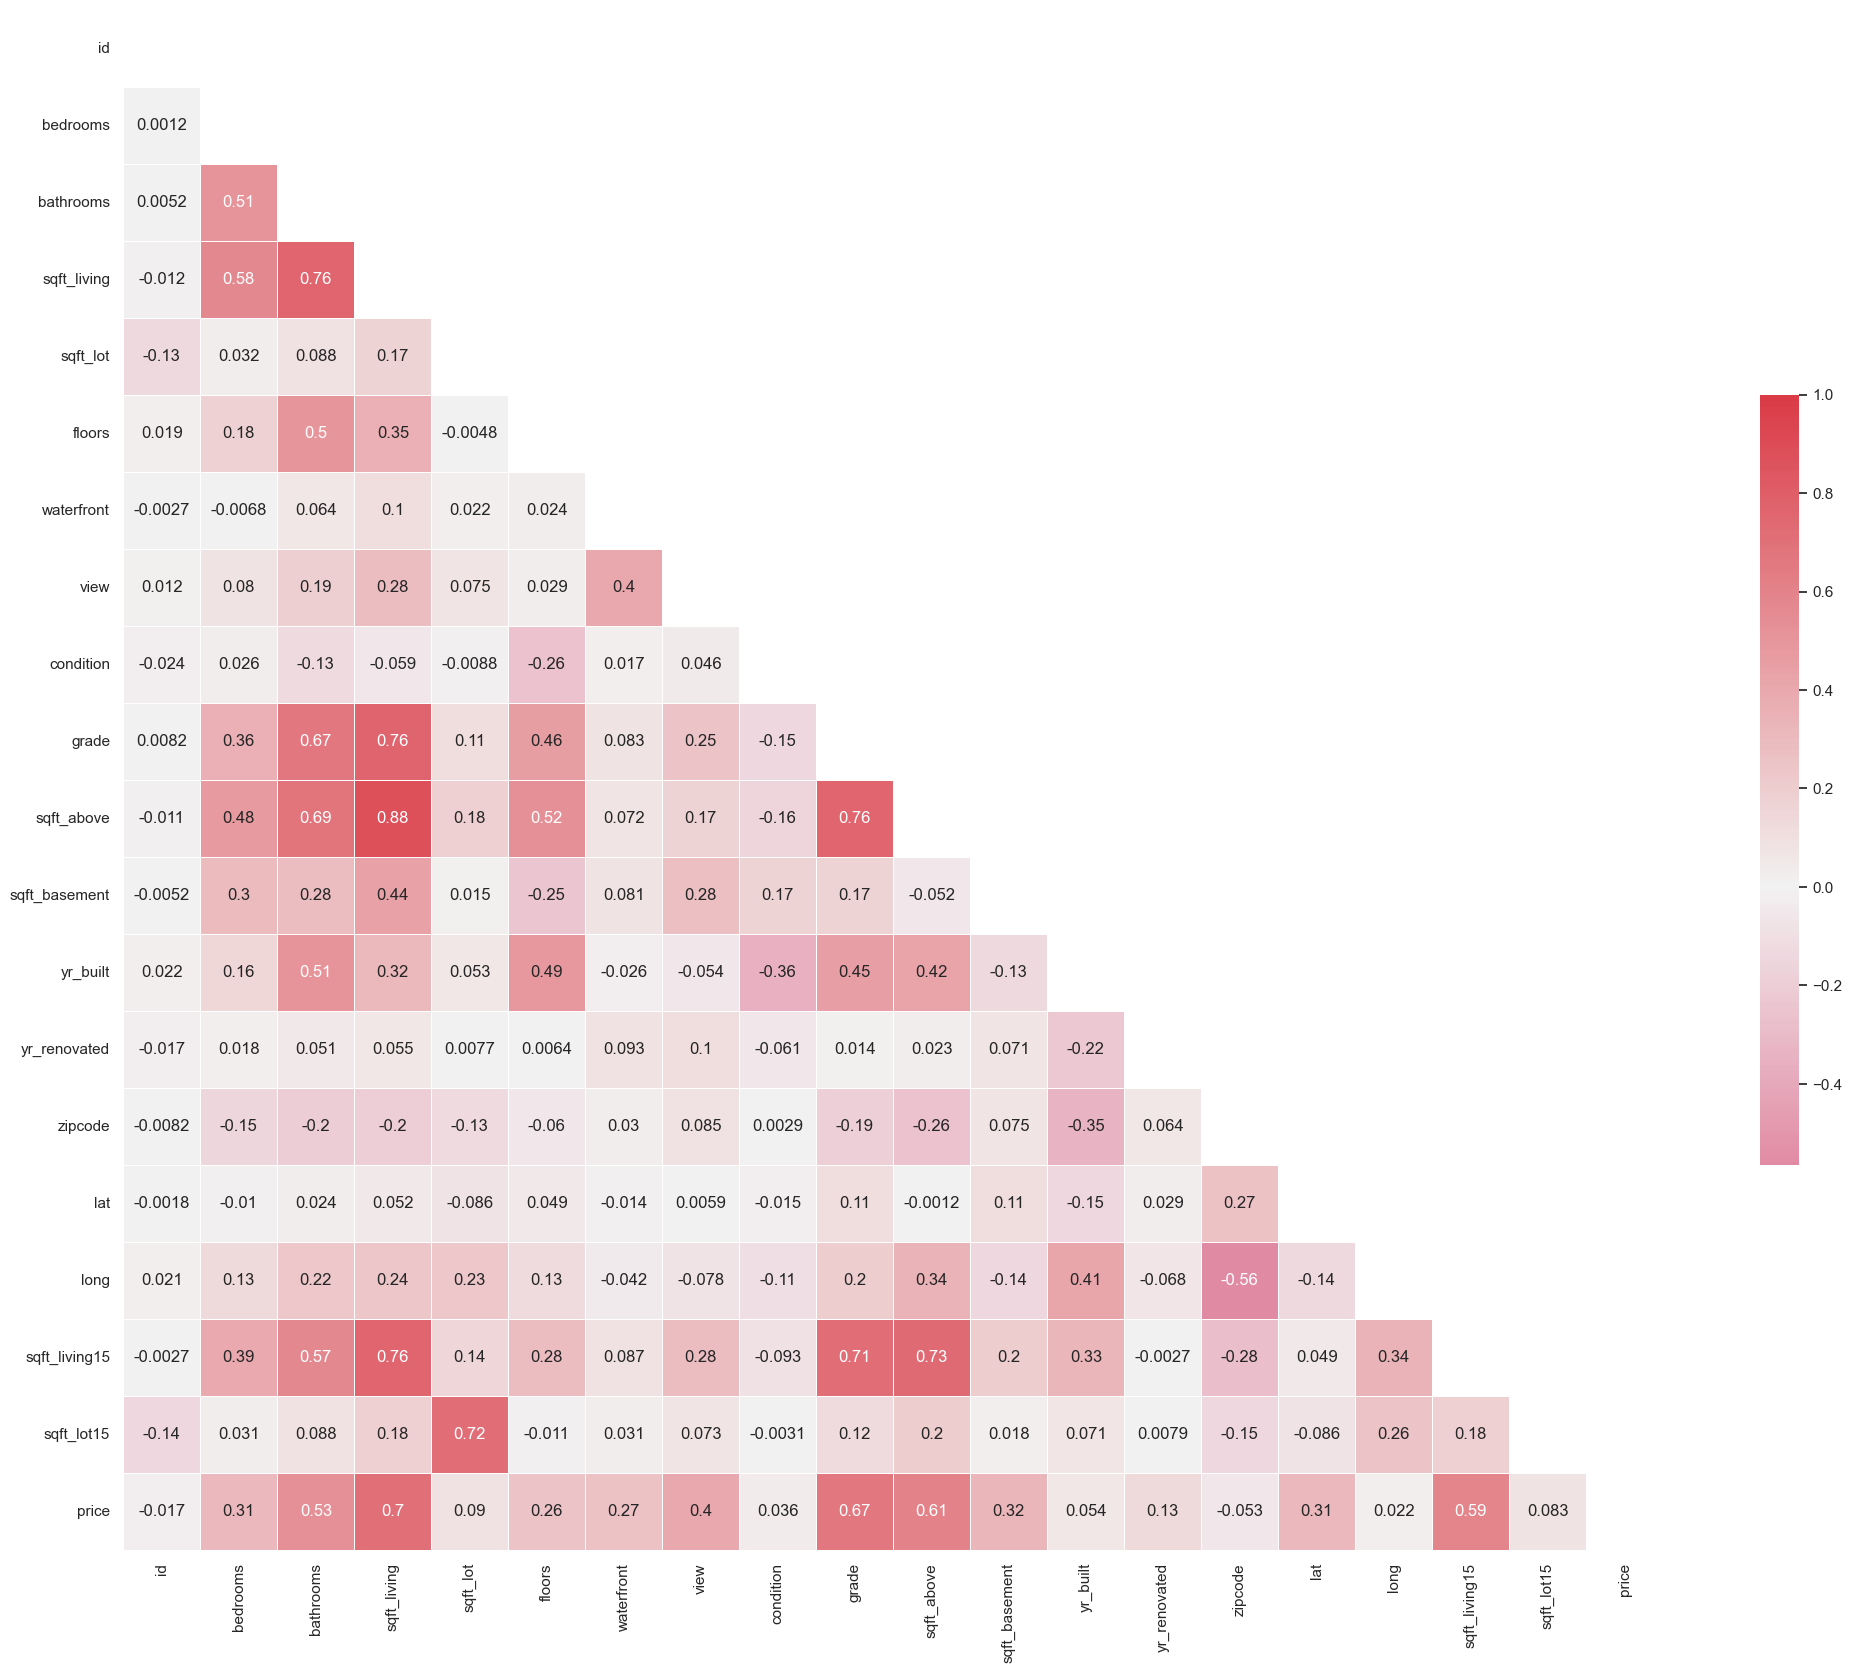

In [37]:
plt.rcParams['figure.figsize']=(25, 20)  # tamaño por defecto para los plots
def print_heatmap_corr(data:pd.DataFrame, annot:bool=True, cmap:str=None, 
                       mask:bool=True, save:bool=False, title:str=None)->None:
    
    '''
        Función que recibe un dataframe y devuelve la matriz de correlación en forma de mapa de color
        
        Parameters:
        -----------
        
        data: Dataset sobre el que queremos realizar la matriz de correlación
        annot: Si queremos mostrar el valor de la correlación en la matriz, default = True
        cmap: Paleta de colores que queremos usar para nuestro heatmap
        mask: Parámetro para mostrar solo la triangular inferior de la matriz de correlación
        save: Parámetro para salvar nuestro gráfico
        title: Título que queremos que lleve nuestro gráfico
    '''
    
    sns.set(style='white')     # estilo blanco hace que el fondo de la matriz sea transparente

    if mask: # Si mask es True
        mascara=np.triu(np.ones_like(data.corr(), dtype=bool))   # genera una mascara para tapar valores
    else:
        mascara = None # No aplicamos máscar

    if cmap: # Si le hemos pasado una paleta de colores
        c_map = sns.color_palette(cmap, as_cmap=True)
    else:
        c_map=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de colores por defecto


    p = sns.heatmap(data.corr(), # aplica el método corr() a nuestro dataset
            mask=mascara, # aplica la mascara
            cmap=c_map, # aplica la paleta de colores
            vmax=1, # para establecer el valor máximo de valores
            center=0, # establece el centro de la paleta de colores
            square=True,
            linewidth=0.5, # para aplicar borde a los cuadros de la matriz
            cbar_kws={'shrink': 0.5}, # mostrar leyenda de colores
            annot=annot # mostrar valores de la matriz
           )
    p.set_title(title, fontsize=20)
    
    if save:
        try:
            plt.savefig(f'graphics/{title}.png')
        except:
            destino = input('No exite la carpeta de destino, introduce un nombre para la carpeta de destino: ')
            os.mkdir(destino)
            plt.savefig(f'{destino}/{title}.png')
    
    plt.show();
    

print_heatmap_corr(casas)

In [38]:
type( casas.price)

pandas.core.series.Series

In [39]:
casas.drop("id", axis="columns", inplace=True) #no es relevante porque no aporta informacion acerca del precio
#casas.drop("lat", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona
casas.drop("long", axis="columns", inplace=True)#no es relevante porque todas las casas estan en la misma zona
casas.drop("zipcode", axis="columns", inplace=True) # no es relevante porque todas las casas estan en la misma zona

In [40]:
# creo una columna que calcula los metros cuadrados totales incluyendo sotano, plantas y terreno sea o no  habitable
casas["sqft_total"]= sum(sum(casas["sqft_lot"] , casas["sqft_above"]) , casas["sqft_basement"])
casas.drop("sqft_lot", axis="columns", inplace=True)
casas.drop("sqft_above", axis="columns", inplace=True)
casas.drop("sqft_basement", axis="columns", inplace=True)

In [41]:
# creo una nueva columna last renovation, que junta las columnas year_built y year_renovated
casas["last_renovation"] = casas[["yr_built","yr_renovated"]].max(axis=1)
casas.drop("yr_built", axis="columns", inplace=True)
#casas.drop("yr_renovated", axis="columns", inplace=True)

In [42]:
#casas.drop("bedrooms", axis="columns", inplace=True) # esta información es no es util sabiendo los metros cuadrados
#casas.drop("bathrooms", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("condition", axis="columns", inplace=True) #condition no es utill sabiendo el grade
#casas.drop("floors", axis="columns", inplace=True) # esta informacion no es util sabiendo los metros cuadrados
#casas.drop("waterfront", axis="columns", inplace=True) #esta informacion no es util pues el precio es equivalente con o sin waterfront
#casas.drop("sqft_lot15", axis="columns", inplace=True)

In [43]:
"""""
def remove_outliers_from_dataframe(df, col, threshold: float = 3):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    intraquartile_range = q3 - q1
    fence_low  = q1 - threshold * intraquartile_range
    fence_high = q3 + threshold * intraquartile_range
    return df.loc[(df[col] > fence_low) & (df[col] < fence_high)]


casas=remove_outliers_from_dataframe(casas, "sqft_living")

casas.info()
#casas.drop("sqft_total", axis="columns", inplace=True)
"""

'""\ndef remove_outliers_from_dataframe(df, col, threshold: float = 3):\n    q1 = df[col].quantile(0.25)\n    q3 = df[col].quantile(0.75)\n    intraquartile_range = q3 - q1\n    fence_low  = q1 - threshold * intraquartile_range\n    fence_high = q3 + threshold * intraquartile_range\n    return df.loc[(df[col] > fence_low) & (df[col] < fence_high)]\n\n\ncasas=remove_outliers_from_dataframe(casas, "sqft_living")\n\ncasas.info()\n#casas.drop("sqft_total", axis="columns", inplace=True)\n'

In [44]:
#casas.drop("last_renovation", axis="columns", inplace=True)
#casas.drop("sqft_total", axis="columns", inplace=True)
#casas.drop("view", axis="columns", inplace=True)
#asas.drop("sqft_living", axis="columns", inplace=True)

In [45]:
#reordeno las columnas para que price esté al final
precio = casas['price'] 
n= len(casas.columns)
casas.drop(labels=['price'], axis="columns",inplace = True)
casas.insert(n-1, 'price', precio)


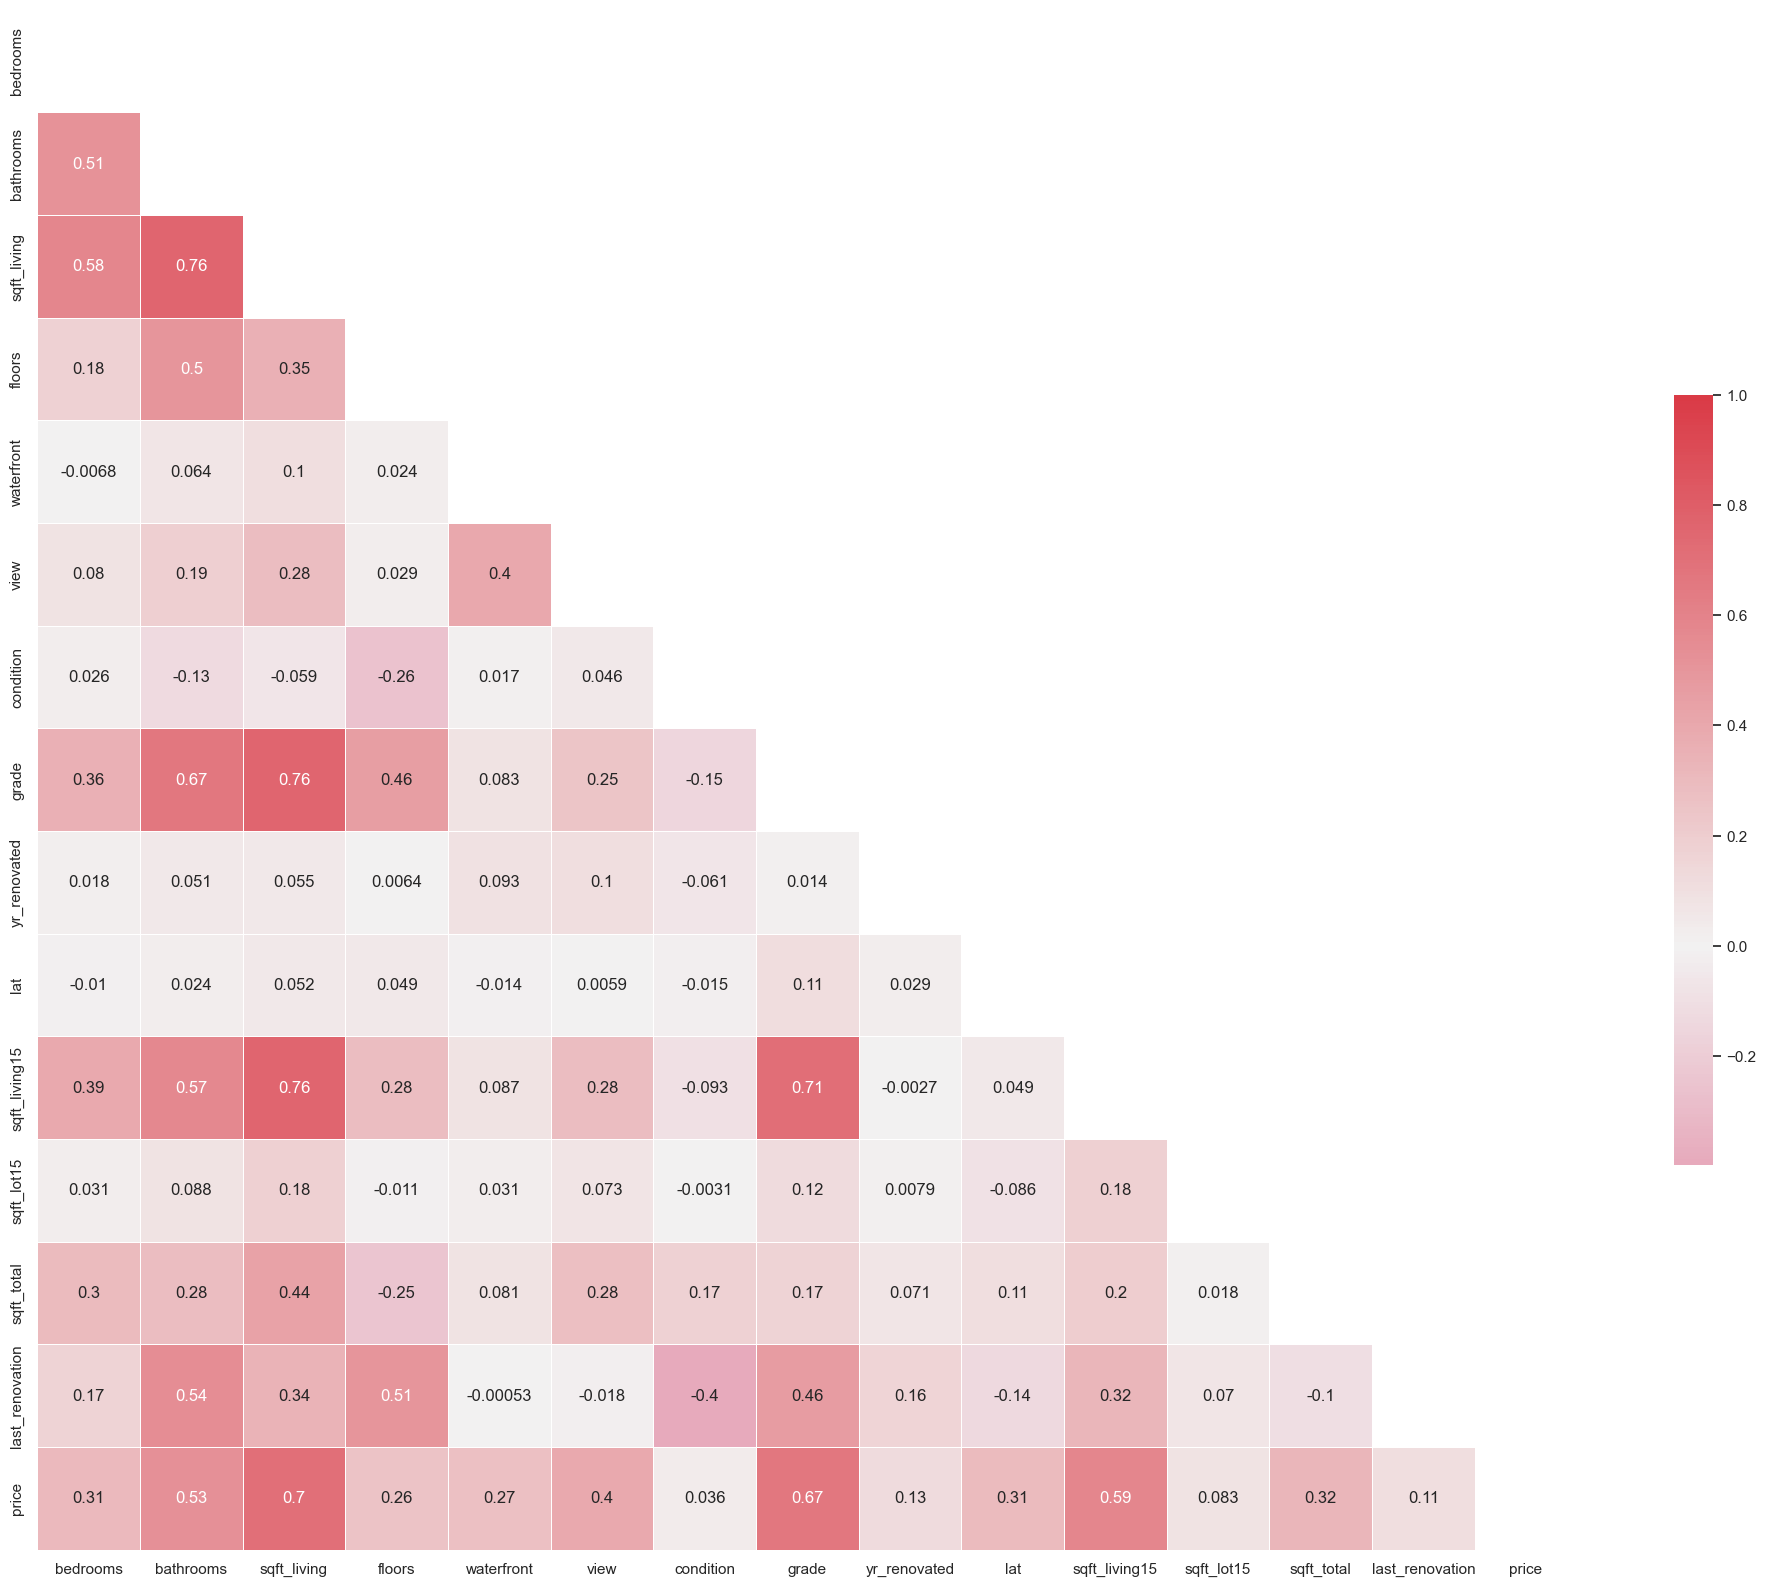

In [46]:
print_heatmap_corr(casas)

In [47]:
casas.corr()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated,lat,sqft_living15,sqft_lot15,sqft_total,last_renovation,price
bedrooms,1.000000,0.514508,0.578212,0.177944,-0.006834,0.080008,0.026496,0.356563,0.018389,-0.009951,0.393406,0.030690,0.302807,0.166855,0.308787
bathrooms,0.514508,1.000000,0.755758,0.502582,0.063744,0.188386,-0.126479,0.665838,0.050544,0.024280,0.569884,0.088303,0.283434,0.538272,0.525906
sqft_living,0.578212,0.755758,1.000000,0.353953,0.103854,0.284709,-0.059445,0.762779,0.055308,0.052155,0.756402,0.184342,0.435126,0.343832,0.701917
floors,0.177944,0.502582,0.353953,1.000000,0.023755,0.028814,-0.264075,0.458794,0.006427,0.049239,0.280102,-0.010722,-0.245723,0.505319,0.256804
waterfront,-0.006834,0.063744,0.103854,0.023755,1.000000,0.401971,0.016611,0.082888,0.092873,-0.014306,0.086507,0.030781,0.080559,-0.000526,0.266398
view,0.080008,0.188386,0.284709,0.028814,0.401971,1.000000,0.045999,0.251728,0.103951,0.005871,0.280681,0.072904,0.277078,-0.018442,0.397370
condition,0.026496,-0.126479,-0.059445,-0.264075,0.016611,0.045999,1.000000,-0.146896,-0.060788,-0.015102,-0.093072,-0.003126,0.173853,-0.396614,0.036056
grade,0.356563,0.665838,0.762779,0.458794,0.082888,0.251728,-0.146896,1.000000,0.014261,0.113575,0.713867,0.120981,0.168216,0.461655,0.667951
yr_renovated,0.018389,0.050544,0.055308,0.006427,0.092873,0.103951,-0.060788,0.014261,1.000000,0.029350,-0.002695,0.007944,0.071234,0.164657,0.126424
lat,-0.009951,0.024280,0.052155,0.049239,-0.014306,0.005871,-0.015102,0.113575,0.029350,1.000000,0.048679,-0.086139,0.110413,-0.135813,0.306692


In [48]:
X= casas.drop(["price","date"], axis="columns") 
y= casas["price"]

In [49]:
def plot_regression_model(x,y):
    
    x_const = add_constant(x) # add a constant to the model
    
    modelo = OLS(y, x_const).fit() # fit the model
    
    pred = modelo.predict(x_const) # make predictions
    
    print(modelo.summary());
    try:
        const = modelo.params[0] # create a variable with the value of the constant given by the summary
        coef = modelo.params[1] # create a variable with the value of the coef given by the summary

        x_l=np.linspace(x.min(), x.max(), 50) 
        y_l= coef*x_l + const # function of the line

        plt.figure(figsize=(10, 10));

        # plot the line
        plt.plot(x_l, y_l, label=f'{x.name} vs {y.name}={coef}*{x.name}+{const}');

        # data
        plt.scatter(x, y, marker='x', c='g', label=f'{x.name} vs {y.name}');

        plt.title('Regresion lineal')
        plt.xlabel(f'{x.name}')
        plt.ylabel(f'{y.name}')
        plt.legend()
        plt.show();
        return modelo
    except:
        print('No se puede imprimir la recta de regresión para modelos multivariable')
        plt.show();
        return modelo



In [50]:
"""
for c in X:
    plot_regression_model(X[c], y)

"""

'\nfor c in X:\n    plot_regression_model(X[c], y)\n\n'

In [51]:
multi = plot_regression_model(X,y)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     3750.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:34:36   Log-Likelihood:            -2.9463e+05
No. Observations:               21597   AIC:                         5.893e+05
Df Residuals:                   21583   BIC:                         5.894e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.485e-05   6.48e-07    -

<Figure size 1000x1000 with 0 Axes>

In [52]:
ln= LinearRegression()
ln.fit(X,y)





LinearRegression()

In [53]:
X_train ,X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2)

In [54]:


X_train.shape, X_test.shape, y_train.shape, y_test.shape


((17277, 14), (4320, 14), (17277,), (4320,))

In [55]:


sc = StandardScaler().fit(X_train)



In [56]:

X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)


X_train.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,condition,grade,yr_renovated,lat,sqft_living15,sqft_lot15,sqft_total,last_renovation
6243,4,2.00,1440,2.0,0,0,4,7,0,47.5717,1300,4080,7042862032133,1972
8986,3,1.75,1430,1.0,0,2,4,7,0,47.4964,1310,9880,7042862032423,1980
9419,4,2.75,3120,2.0,0,0,3,9,0,47.5940,3200,5000,7042862032133,2010
10155,4,2.50,2060,1.0,0,0,3,7,0,47.7251,1760,7350,7042862032973,1974
10436,3,2.00,2500,1.5,0,0,5,7,0,47.6813,1550,3060,7042862032953,1922


In [57]:
X_train_sc

array([[ 6.91203271e-01, -1.49232854e-01, -7.01341837e-01, ...,
        -3.22385502e-01, -6.60789372e-01, -4.60477289e-02],
       [-4.14529962e-01, -4.74898638e-01, -7.12240729e-01, ...,
        -1.07778126e-01, -7.12523841e-03,  2.31564279e-01],
       [ 6.91203271e-01,  8.27764499e-01,  1.12967201e+00, ...,
        -2.88344332e-01, -6.60789372e-01,  1.27260931e+00],
       ...,
       [ 6.91203271e-01, -8.00564422e-01, -6.03251810e-01, ...,
        -1.58839881e-01, -6.60789372e-01,  9.27582750e-02],
       [-2.62599643e+00, -1.77756177e+00, -1.85662439e+00, ...,
         8.16683861e-02, -6.60789372e-01, -3.58361238e-01],
       [ 6.91203271e-01,  5.02098714e-01,  7.31862457e-01, ...,
         1.41262748e-03, -6.60789372e-01,  9.60295799e-01]])

In [58]:

linreg=LinearRegression()
lasso=Lasso() # Favorece si nuestras betas son próximas a 0 L1
ridge=Ridge() # Favorece cuando hay sospechas de correlación entre caracteristicas L2
elastic=ElasticNet() # Mezcla de las anteriores, funciona bien cuando hay muchas características (L1+L2)


In [59]:

linreg.fit(X_train_sc, y_train)
lasso.fit(X_train_sc, y_train)
ridge.fit(X_train_sc, y_train)
elastic.fit(X_train_sc, y_train)


ElasticNet()

In [60]:
y.describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [61]:
from sklearn.metrics import mean_squared_error as mse

print(f' MSE linreg en train: {mse(y_train, linreg.predict(X_train_sc))}\n')
print(f' MSE linreg en test: {mse(y_test, linreg.predict(X_test_sc))}\n')
print(f' MSE lasso en train: {mse(y_train, lasso.predict(X_train_sc))}\n')
print(f' MSE lasso en test: {mse(y_test, lasso.predict(X_test_sc))}\n')
print(f' MSE ridge en train: {mse(y_train, ridge.predict(X_train_sc))}\n')
print(f' MSE ridge en test: {mse(y_test, ridge.predict(X_test_sc))}\n')
print(f' MSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc))}\n')
print(f' MSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc))}\n')

 MSE linreg en train: 41375560781.819916

 MSE linreg en test: 41408512798.97548

 MSE lasso en train: 41375560800.28806

 MSE lasso en test: 41408417737.02999

 MSE ridge en train: 41375561268.4555

 MSE ridge en test: 41408371187.94676

 MSE ElasticNet en train: 46867278954.571655

 MSE ElasticNet en test: 46013968197.75232



In [62]:
print(f' RMSE linreg en train: {mse(y_train, linreg.predict(X_train_sc), squared=False)}\n')
print(f' RMSE linreg en test: {mse(y_test, linreg.predict(X_test_sc), squared=False)}\n')
print(f' RMSE lasso en train: {mse(y_train, lasso.predict(X_train_sc), squared=False)}\n')
print(f' RMSE lasso en test: {mse(y_test, lasso.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ridge en train: {mse(y_train, ridge.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ridge en test: {mse(y_test, ridge.predict(X_test_sc), squared=False)}\n')
print(f' RMSE ElasticNet en train: {mse(y_train, elastic.predict(X_train_sc), squared=False)}\n')
print(f' RMSE ElasticNet en test: {mse(y_test, elastic.predict(X_test_sc), squared=False)}\n')

 RMSE linreg en train: 203409.83452581617

 RMSE linreg en test: 203490.81748072928

 RMSE lasso en train: 203409.83457121256

 RMSE lasso en test: 203490.58390262187

 RMSE ridge en train: 203409.835722011

 RMSE ridge en test: 203490.46952608557

 RMSE ElasticNet en train: 216488.5192211625

 RMSE ElasticNet en test: 214508.66695253205



In [63]:


from sklearn.metrics import mean_absolute_error as mae

print(f' MAE linreg en train: {mae(y_train, linreg.predict(X_train_sc))}\n')
print(f' MAE linreg en test: {mae(y_test, linreg.predict(X_test_sc))}\n')
print(f' MAE lasso en train: {mae(y_train, lasso.predict(X_train_sc))}\n')
print(f' MAE lasso en test: {mae(y_test, lasso.predict(X_test_sc))}\n')
print(f' MAE ridge en train: {mae(y_train, ridge.predict(X_train_sc))}\n')
print(f' MAE ridge en test: {mae(y_test, ridge.predict(X_test_sc))}\n')
print(f' MAE ElasticNet en train: {mae(y_train, elastic.predict(X_train_sc))}\n')
print(f' MAE ElasticNet en test: {mae(y_test, elastic.predict(X_test_sc))}\n')


 MAE linreg en train: 126885.79485475655

 MAE linreg en test: 126641.30302675429

 MAE lasso en train: 126885.30372808677

 MAE lasso en test: 126640.74759995312

 MAE ridge en train: 126882.60089518389

 MAE ridge en test: 126638.23701734659

 MAE ElasticNet en train: 126184.82207820746

 MAE ElasticNet en test: 125540.10302611112



In [64]:

print(f' R2 linreg en train: {linreg.score(X_train_sc, y_train)}\n')
print(f' R2 linreg en test: {linreg.score(X_test_sc, y_test)}\n')
print(f' R2 lasso en train: {lasso.score(X_train_sc, y_train)}\n')
print(f' R2 lasso en test: {lasso.score(X_test_sc, y_test)}\n')
print(f' R2 ridge en train: {ridge.score(X_train_sc, y_train)}\n')
print(f' R2 ridge en test: {ridge.score(X_test_sc, y_test)}\n')
print(f' R2 ElasticNet en train: {elastic.score(X_train_sc, y_train)}\n')
print(f' R2 ElasticNet en test: {elastic.score(X_test_sc, y_test)}\n')



 R2 linreg en train: 0.6960585606736247

 R2 linreg en test: 0.6820020295241629

 R2 lasso en train: 0.6960585605379592

 R2 lasso en test: 0.6820027595553495

 R2 ridge en train: 0.6960585570988401

 R2 ridge en test: 0.6820031170304917

 R2 ElasticNet en train: 0.655716854258992

 R2 ElasticNet en test: 0.6466342905996136

